In [1]:
# Standard library imports
import random

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from scipy.special import comb
from scipy.optimize import fsolve

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Custom colormaps
sunset = [
    "#a50026", "#d73027", "#f46d43", "#fdae61", "#fee090", "#e0f3f8", "#abd9e9", "#74add1", "#4575b4", "#313695"
]

ptog = [
    "#40004b", "#762a83", "#9970ab", "#c2a5cf", "#e7d4e8",
    "#d9f0d3", "#a6dba0", "#5aae61", "#1b7837", "#00441b"
]

# General definitions

In [4]:
def compute_Pm(J):
    N = J.shape[0]
    dp = torch.zeros(2 * N + 1, dtype=J.dtype, device=J.device)
    dp[N] = 1.0
    m_vector = torch.arange(-N, N + 1, dtype=J.dtype, device=J.device)
    for l in range(N):
        new_dp = torch.zeros_like(dp)
        up = torch.sigmoid(2 * J[l] * m_vector[:-1])
        new_dp[1:] += dp[:-1] * up
        down = 1 - torch.sigmoid(2 * J[l] * m_vector[1:])
        new_dp[:-1] += dp[1:] * down
        dp = new_dp
    return dp.to(device)

In [5]:
import torch

def transition_matrix_global(probMADE, beta, N):
    device = probMADE.device
    M = len(probMADE)  # M should be N/2 + 1
    
    # Compute m values and their squares: m_i = 2*i/N, with m_max = 1
    m_vals = torch.arange(M, dtype=torch.float64, device=device) * (2.0 / N)
    m2 = m_vals ** 2

    # Precompute the configuration counts (degeneracies) using lgamma for a vectorized comb
    # For i=0: config[0] = comb(N, N//2), and for i>0: config[i] = 2 * comb(N, (N//2) + i)
    indices = torch.arange(M, dtype=torch.float64, device=device)
    k = (N // 2) + indices  # k-values: starting from N//2
    N_tensor = torch.tensor(N, dtype=torch.float64, device=device)
    comb_k = torch.exp(torch.lgamma(N_tensor + 1) - torch.lgamma(k + 1) - torch.lgamma(N_tensor - k + 1))
    config = comb_k.clone()
    if M > 1:
        config[1:] = 2 * config[1:]
    
    # Compute the exponent matrix for all (i, j)
    # exponent[i,j] = 0.5 * beta * N * (m_vals[j]^2 - m_vals[i]^2)
    exponent_matrix = 0.5 * beta * N * (m2[None, :] - m2[:, None])
    exp_matrix = torch.exp(exponent_matrix)
    
    # Compute the ratio matrix (for all i, j):
    # ratio[i,j] = exp_matrix[i,j] * (probMADE[i]*config[j])/(probMADE[j]*config[i])
    ratio = exp_matrix * ((probMADE[:, None] * config[None, :]) / (probMADE[None, :] * config[:, None]))
    
    # Apply the min operation elementwise to get alpha: alpha[i,j] = min(1, ratio[i,j])
    ones = torch.ones_like(ratio)
    alpha = torch.minimum(ones, ratio)
    
    # Off-diagonals: set T[i,j] = probMADE[j] * alpha[i,j]
    T = probMADE[None, :] * alpha
    
    # Exclude the diagonal from the sum and then define T[i,i] = 1 - sum_{j != i} T[i,j]
    # First, zero out the diagonal values in T (they are not used in the off-diagonal sum)
    T.fill_diagonal_(0)
    diag = 1 - T.sum(dim=1)
    T.diagonal(dim1=0, dim2=1).copy_(diag)
    
    return T


# transition matrix for the Markov chain
def transition_matrix_local(N, beta):
    """
    Get the transition matrix for the system in magnetization space.

    Parameters:
    - N (int): The number of spins in the system.
    - beta (float): The inverse temperature (1/kT) of the system.

    Returns:
    - torch.Tensor: A transition matrix of shape ((N/2)+1, (N/2)+1) representing 
                  the probabilities of transitioning between different magnetization states.
    """
    M = int(N / 2) + 1
    P = torch.zeros((M, M), device=device, dtype=torch.float64)

    m_vals = torch.arange(M, dtype=torch.float64, device=device) * (2.0 / N)

    for i in range(M):
        m = m_vals[i]
        if i == 0:
            P[i, 1] = 1.0
        else:
            P[i, i - 1] = (1 + torch.abs(m)) / 2 * torch.exp(-2 * beta * (torch.abs(m) - 1 / N))
            P[i, i] = 1 - (1 + torch.abs(m)) / 2 * torch.exp(-2 * beta * (torch.abs(m) - 1 / N)) - (1 - torch.abs(m)) / 2
            if i != M - 1:
                P[i, i + 1] = (1 - torch.abs(m)) / 2

    return P

In [6]:
def compute_Pm_abs(N, W):
    Neff = int(N/2)
    probMADE = compute_Pm(torch.tensor(W).to(device))[::2]
    x = probMADE[Neff:]
    x[1:] += torch.flip(probMADE[:Neff], dims=[0])
    probMADE = x
    return probMADE

def get_matrix_mixed(N, beta_target, W, k):
    probMADE = compute_Pm_abs(N, W)
    Tmade = transition_matrix_global(probMADE, beta_target, N)
    Tlocal = transition_matrix_local(N, beta_target)
    T = torch.matmul(Tmade, torch.matrix_power(Tlocal, N * k).to(device))
    return T

In [7]:
def mhat(beta):
    """
    Solves the equation m = tanh(beta * m) for m as a function of beta.

    Parameters:
    - beta (float): The value of beta.

    Returns:
    - float: The solution for m.
    """
    # Define the self-consistent equation
    def self_consistent_eq(m):
        return m - np.tanh(beta * m)
    
    # Initial guess for m
    m_initial = 0.5
    
    # Solve the equation using fsolve
    m_solution = fsolve(self_consistent_eq, m_initial)
    
    return m_solution[0]

# Comparison with the simulations

## Definitions

In [44]:
class AutoregressiveMasking(object):
    """Autoregressive constraint for weight matrices."""
    def __init__(self, frequency=1):
        """
        Constructor for AutoregressiveMasking.

        Parameters:
        - frequency (int): Controls how often the autoregressive constraint is applied.
        """
        self.frequency = frequency

    def __call__(self, module):
        """
        Applies the autoregressive constraint to the weight matrices of a module.

        Parameters:
        - module: PyTorch module to which the constraint is applied.
        """
        # Apply autoregressive constraint to weight matrices
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = torch.tril(w, -1)  # Apply lower triangular masking
            module.weight.data = w

# Build the autoregressive model
class made(nn.Module):
    """Autoregressive MADE (Masked Autoencoder for Distribution Estimation)."""
    def __init__(self, input_size):
        """
        Constructor for the MADE model.

        Parameters:
        - input_size (int): Size of the input features.
        """
        super(made, self).__init__()
        self.layer = nn.Linear(input_size, input_size, bias=False)
        # self.constraint = AutoregressiveConstraint()  # Commented out, not used in forward pass
        self.activation = nn.Sigmoid()

    def forward(self, x):
        """
        Forward pass of the MADE model.

        Parameters:
        - x: Input tensor to the model.

        Returns:
        - x: Output tensor after the forward pass.
        """
        x = self.layer(x)
        # x = self.constraint(x)  # Commented out, not used in the forward pass
        x = self.activation(2 * x)  # Apply activation function
        if device == "cuda":
            torch.cuda.empty_cache()  # Clear GPU cache
        return x
    
    def forward_n(self, input, n):
        # Get the n-th row of the weight matrix of the linear layer
        nth_row = self.layer.weight[n]
        x = torch.einsum("ij, j->i", input[:, :n], nth_row[:n])
        x = self.activation(2 * x)
        return x

In [45]:
def setup_model(W, N = 100):
    model = made(N)
    weights = model.layer.weight.detach()

    # Update each row i of the weight matrix with W[i]
    for i in range(weights.shape[0]):
        weights[i, :] = W[i]

    # Set the upper triangular part of the matrix to 0
    weights = np.tril(weights, -1)  # Keep only the lower triangular part

    # Set the updated weights back to the model
    model.layer.weight.data = torch.tensor(weights)
    model = model.cuda()
    return model

In [46]:
def generate_config_fast(model, N_spins, N_config, J):
    """
    Generate N_config spin configurations with N_spins using the MADE.

    Parameters:
    - model: Autoregressive model used for spin generation.
    - N_spins: Number of spins in each configuration.
    - N_config: Number of configurations to generate.

    Returns:
    - Tensor: A tensor containing generated spin configurations with shape (N_config, N_spins).
    """

    with torch.no_grad():
        # Initialize a tensor with random binary configurations (values of -1 or 1)
        #config = (torch.bernoulli(torch.full((N_config, N_spins), 0.5)) * 2 - 1).to("cuda")
        #config = torch.ones((N_config, N_spins)).to("cuda")
        config = torch.zeros((N_config, N_spins)).to("cuda")
    
        # Generate each spin in an autoregressive manner
        for n in range(N_spins):
            # Get probabilities from the autoregressive model for the nth spin
            probs = model.forward_n(config, n)
            
            # Sample new spin values based on probabilities and update the configuration
            config[:, n] = (torch.bernoulli(probs) * 2 - 1)
            torch.cuda.empty_cache()
    
    return config

def MLMC_fast(model, data, beta, N,  num_steps = 10, return_correlations = False):
    # NOTA: le correlazioni sono calcolate usando come riferimento il primo campione
    # Non sono mediate sui tempi!
    #Se il primo campione è all'equilibrio, non ci sono problemi
    acc_rates = []
    if return_correlations:
        correlations = [1]
    with torch.no_grad():
        bce = nn.BCELoss(reduction = "none")
        current_config = data.clone()
        for t in range(num_steps):
            new_config = generate_config_fast(model, N, len(data), None)
            
            current_energy = -N*current_config.mean(1)**2/2
            current_probability = torch.sum(bce(model(current_config), (current_config+1)/2), axis = 1)

            new_energy = -N*new_config.mean(1)**2/2
            new_probability = torch.sum(bce(model(new_config), (new_config+1)/2), axis = 1)

            arg_new = -beta*new_energy + new_probability
            arg_current = -beta*current_energy + current_probability

            acceptances = (torch.log(torch.rand(size=(len(data),), device = "cuda")) < (arg_new-arg_current)).int()
            current_config = torch.einsum("i, ij->ij",(1-acceptances),current_config) + torch.einsum("i, ij->ij",acceptances, new_config)
            torch.cuda.empty_cache()
            acc_rates.append(torch.sum(acceptances)/len(data))
            if return_correlations:
                correlations.append(float(torch.mean(data*current_config) - torch.mean(data)*torch.mean(current_config)))
    if return_correlations:
        return current_config, acc_rates, correlations
    else:
        return current_config, acc_rates

def monte_carlo_update_CW(pop, N, beta):
    """Monte Carlo update model using a checkerboard pattern."""
    population = pop.clone()
    pop_size, N = population.shape
    # Define "even" and "odd" indices for a checkerboard update

    # Update spins in two passes (checkerboard pattern)
    random_indices = torch.randint(0, N, (pop_size,))
    magnetizations = population.mean(1)
    sigmas = population[torch.arange(pop_size), random_indices]
    
    # Compute energy difference for each single-spin flip
    delta_E = -2*(1/N - sigmas*magnetizations)
    # Metropolis acceptance criterion for each spin
    acceptance_prob = torch.exp(-beta * delta_E)
    random_vals = torch.rand(pop_size, device=population.device)
    accept = (delta_E < 0) | (random_vals < acceptance_prob)
    
    # Apply accepted flips only for accepted positions
    population[torch.arange(pop_size), random_indices] = torch.where(accept, -sigmas, sigmas)
    return population

In [47]:
def montecarlo_alternated_abs(N, beta, target_M, model, pop_size = 10000, k = 1):
    # Population of spins, randomly initialized to -1 or 1
    pop = torch.cat([torch.ones((pop_size, N//2)), -torch.ones((pop_size, N//2))], dim=1).cuda()
    # Apply random permutation to each row
    pop = torch.stack([row[torch.randperm(row.size(0))] for row in pop])
    over = False

    # Array to track the time (iteration count) at which each population member reaches the target magnetization
    time_to_target = torch.full((pop_size,), float('inf'), device="cuda")  # Initialized to infinity (not reached yet)

    # Flag to indicate whether each population member has reached the target
    reached_target = torch.zeros(pop_size, dtype=torch.bool, device="cuda")

    magnetizations = pop.sum(1)  
        
    # Check which members have reached the target magnetization (absolute value comparison)
    newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
    
    # Update the time for newly reached members (only for the first time they reach the target)
    time_to_target[newly_reached] = 0
    # Mark members as having reached the target
    reached_target |= newly_reached

    # Loop to update the population using the Monte Carlo method
    for global_step in range(1, 1000):  # Maximum number of iterations
        #pop, _ = MLMC_fast(model, pop, beta, N,  num_steps = 1)
        # Calculate magnetization for each population member
        #magnetizations = pop.sum(1)  
        
        # Check which members have reached the target magnetization (absolute value comparison)
        #newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
        
        # Update the time for newly reached members (only for the first time they reach the target)
        #time_to_target[newly_reached] = N+N+global_step*(N+N*k)
        
        # Mark members as having reached the target
        #reached_target |= newly_reached
        
        # Break if all members of the population have reached the target
        #if reached_target.all():
        #    print("All population members have reached the target magnetization.")
        #    over = True
        #    break
        #
        # Perform a Monte Carlo update for the entire population
        pop, _ = MLMC_fast(model, pop, beta, N,  num_steps = 1)
        for i in range(N*k):
            pop = monte_carlo_update_CW(pop, N, beta)  
        
        # Calculate magnetization for each population member
        magnetizations = pop.sum(1)  
        
        # Check which members have reached the target magnetization (absolute value comparison)
        newly_reached = (torch.abs(magnetizations) >= target_M) & ~reached_target
        
        # Update the time for newly reached members (only for the first time they reach the target)
        time_to_target[newly_reached] = global_step
        
        # Mark members as having reached the target
        reached_target |= newly_reached
        
        # Break if all members of the population have reached the target
        if reached_target.all():
            print("All population members have reached the target magnetization.")
            over = True
            break
        if over:
            break

    # Print or save the times to target
    #print("Time to target for each population member:", time_to_target)
    return time_to_target

## Result

In [48]:
beta = 1
N = 200

W = np.concatenate([np.array([0]),np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

model = setup_model(W, N=N)

In [50]:
beta = 1
N = 200

W = np.concatenate([np.array([0]),np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
W *= beta

model = setup_model(W, N=N)

results = []
beta_target = 1.1

for M in np.arange(int(N*0.1), int(N/2), 10):
    mtarget = M/N
    result1 = 2*N*montecarlo_alternated_abs(N, beta_target, int(mtarget*N), model, pop_size = 50000, k = 1).mean()
    #result2 = montecarlo_alternated_abs(N, beta_target, int(mtarget*N), model, pop_size = 10000, k = 0).mean()

    nmax = int((mtarget)*N/2)
    P = get_matrix_mixed(N, beta_target, W, k=1)[:nmax, :nmax]
    P = torch.eye(P.shape[0]).to(device)-P
    P_inv = torch.linalg.inv(P)
    fpt_made = 2*N*torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]
    print(mtarget, result1, fpt_made)

    results.append([mtarget, result1, fpt_made])
results = np.array(results)

All population members have reached the target magnetization.
0.1 tensor(493.0560, device='cuda:0') tensor(492.6134, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.15 tensor(561.1680, device='cuda:0') tensor(561.1256, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.2 tensor(649.7120, device='cuda:0') tensor(650.0633, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.25 tensor(765.1440, device='cuda:0') tensor(766.9187, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.3 tensor(927.2560, device='cuda:0') tensor(922.9173, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.35 tensor(1138.6320, device='cuda:0') tensor(1135.8470, device='cuda:0', dtype=torch.float64)
All population members have reached the target magnetization.
0.4

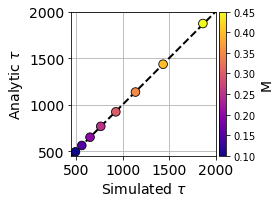

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(4, 4))

# Plot
ax.plot([results[:,1].min()-50, 2000+50], [results[:,1].min()-50, 2000+50],
         'r--', label='Bisettrice', color="black", lw=2)
ax.grid(True)
ax.set_aspect('equal', adjustable='box')

sc = ax.scatter(results[:,1], results[:,2], c=results[:,0],
                cmap='plasma', edgecolor='black', zorder=3, lw=0.8, s=75)

# Colorbar with adjusted size
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)  # size=5% of the main plot
cb = plt.colorbar(sc, cax=cax)
cb.set_label('M', fontsize = 14)

# Labels and legend
#ax.set_title(fr'$\beta={beta_target}, \, N={N}$', fontsize=14)
ax.set_ylabel(r'Analytic $\tau$', fontsize=14)
ax.set_xlabel(r'Simulated $\tau$', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xticks([500, 1000, 1500, 2000])
ax.set_yticks([500, 1000, 1500, 2000])
ax.set_xlim(450, 2000)
ax.set_ylim(450, 2000)
#ax.legend(fontsize=16)
plt.savefig(f"../Plots/FPS_MADE_N{N}_beta{beta_target}.pdf", bbox_inches='tight')
plt.tight_layout()


# Perfectly trained machine

In [8]:
def get_beta(m):
    return np.arctanh(m)/m

In [27]:

all_results = []
Ns = [20,50,100, 200, 350, 500, 700]
steps = [2, 2, 2, 4, 6, 8, 16]

#Ns = [20, 200]
#steps = [2,8]

for i, N in enumerate(Ns):
    beta = 1

    W = np.concatenate([np.array([0]),np.loadtxt(f"../Data/couplings_exact/couplings_N{N}_beta{beta}.txt")]) #Need to add the starting 0
    W *= beta

    probMADE = compute_Pm_abs(N, W)

    results = []
    for M in np.arange(2,int(0.9*N),steps[i]):
        mtarget = M/float(N)
        beta_target = get_beta(mtarget)
        nmax = int((M+1)/2)

        P = get_matrix_mixed(N, beta_target, W, k=1)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device)-P
        P_inv = torch.linalg.inv(P)
        result = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))

        P = get_matrix_mixed(N, beta_target, W, k=0)[:nmax, :nmax]
        P = torch.eye(P.shape[0]).to(device)-P
        P_inv = torch.linalg.inv(P)
        fpt_made = torch.matmul(P_inv, torch.ones(P_inv.shape[0], device=P_inv.device, dtype=P_inv.dtype))[0]

        #cumulative = probMADE[nmax:].sum()
        #fpt_made = 1/cumulative

        print(beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item())
        results.append((beta_target, mtarget, fpt_made.item(), result[0].item() * 2, (result[0].item() * 2) / fpt_made.item()))
    all_results.append(results)

1.0033534773107557 0.1 1.0654479992479606 2.125285131967 1.9947337959873388
1.0136627702704109 0.2 1.2226386710022312 2.4240434255605825 1.9826327132066959
1.0317320140103725 0.3 1.436565291918808 2.8062216174603773 1.9534243471190444
1.0591223254840045 0.4 1.741444014422888 3.301883731904581 1.8960608004379749
1.0986122886681096 0.5 2.2054220223021574 3.951104475508877 1.7915412268280821
1.1552453009332422 0.6 2.9747081359371768 4.790009343756266 1.6102451483856857
1.2390007538486474 0.7 4.408553262061552 5.7907272143640665 1.3135209829939027
1.373265360835137 0.8 7.57853576154271 6.705501257151342 0.8848016910045364
1.0005338459192052 0.04 1.0368047994194487 2.064306452088459 1.991027099068554
1.0021415629698711 0.08 1.1100143907833981 2.205354470223302 1.9867800710825578
1.0048419034037004 0.12 1.1939150455140897 2.3651868087765315 1.981034427586179
1.0086668508220347 0.16 1.2912548129717207 2.547183979856713 1.9726423896105918
1.0136627702704109 0.2 1.405691779915265 2.755911057468

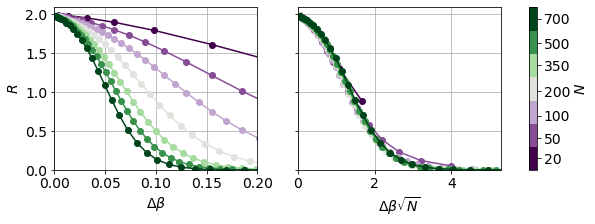

In [40]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Create the custom discrete colormap from your existing custom_cmap.
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ptog", ptog)

Ns = [20, 50, 100, 200, 350, 500, 700]

# Create a discrete colormap using len(Ns) colors.
discrete_colors = custom_cmap(np.linspace(0, 1, len(Ns)))
discrete_cmap = mcolors.ListedColormap(discrete_colors)

# Compute boundaries for the discrete colorbar (midpoints between successive Ns values).
boundaries = [Ns[0] - (Ns[1] - Ns[0]) / 2]
for i in range(len(Ns) - 1):
    boundaries.append((Ns[i] + Ns[i+1]) / 2)
boundaries.append(Ns[-1] + (Ns[-1] - Ns[-2]) / 2)

# Create a norm based on these boundaries.
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(Ns))

# Create a ScalarMappable for the colorbar.
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

# Create a 1 x 2 figure.
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# Loop over each result set and plot in both subplots.
for i, results in enumerate(all_results):
    results = np.array(results)
    # Left subplot: original x-axis (Δβ)
    axs[0].plot(results[:, 0] - 1, results[:, -1],
                marker="o", alpha=1, color=discrete_colors[i])
    # Right subplot: x-axis scaled by √N
    axs[1].plot((results[:, 0] - 1) * np.sqrt(Ns[i]), results[:, -1],
                marker="o", alpha=1, color=discrete_colors[i])

# Formatting for the left subplot.
axs[0].set_xlabel(r'$\Delta \beta$', fontsize=14)
axs[0].set_ylabel(r'$R$', fontsize=14)
axs[0].tick_params(labelsize=14)
axs[0].grid(True)
axs[0].set_xlim(0, 0.20)
axs[0].set_ylim(0, None)

# Formatting for the right subplot.
axs[1].set_xlabel(r'$\Delta \beta \sqrt{N}$', fontsize=14)
#axs[1].set_ylabel(r'$R$', fontsize=14)
axs[1].tick_params(labelsize=14)
axs[1].grid(True)
axs[1].set_xlim(0, 0.20 * np.sqrt(max(Ns)))
axs[1].set_ylim(0, None)

# Add a common discretized colorbar.
cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), boundaries=boundaries, ticks=Ns)
cbar.set_label(r'$N$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

#plt.tight_layout()
plt.savefig(f"../Plots/FPS_diffDB.pdf", bbox_inches='tight')
plt.show()

In [ ]:
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ptog", ptog)

plt.figure(figsize=(5, 3))

Ns = [20, 50, 100, 200, 350, 500, 700]

# Create a discrete colormap from your existing custom_cmap using len(Ns) colors
discrete_colors = custom_cmap(np.linspace(0, 1, len(Ns)))
discrete_cmap = mcolors.ListedColormap(discrete_colors)

# Compute boundaries for the discrete colorbar.
# We set boundaries midway between successive Ns values.
boundaries = [Ns[0] - (Ns[1] - Ns[0]) / 2]
for i in range(len(Ns) - 1):
    boundaries.append((Ns[i] + Ns[i+1]) / 2)
boundaries.append(Ns[-1] + (Ns[-1] - Ns[-2]) / 2)

# Create a norm based on these boundaries.
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(Ns))

# Create a ScalarMappable for the colorbar.
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])

# Plot each result using its corresponding discrete color.
for i, results in enumerate(all_results):
    results = np.array(results)
    plt.plot(results[:, 0] - 1, results[:, -1],
             marker="o", alpha=1,
             color=discrete_colors[i])

plt.xlabel(r'$\Delta \beta$', fontsize=14)
plt.ylabel(r'$R$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.xlim(0, 0.20)
plt.ylim(0, None)

# Add the discretized colorbar with ticks at each N.
cbar = plt.colorbar(sm, boundaries=boundaries, ticks=Ns)
cbar.set_label('N', fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig(f"../Plots/FPS_diffDB.pdf", bbox_inches='tight')
plt.show()